In [1]:
from fastatools import fasta_sequences

import itertools
import operator
from math import log,log2
from collections import Counter,defaultdict

import functools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Exercise 1

#### Exericse 1 (a)

In [3]:

def get_kmers(seq,k):
    """ Generator for k-mers of a sequence
    """
    return (seq[i:i+k] for i in range(len(seq)-k+1))

def init_counter(k,symbols="ACGT"):
    """ Initialize a counter for k-mers over the alphabet symbols
        with a pseudocount of 1
    """
    counter = Counter()
    for kmer in itertools.product(symbols,repeat=k):
        counter[''.join(kmer)] = 1
    return counter

def relative_kmer_frequencies(seqs,k,symbols="ACGT"):
    """ Return the relative k-mer frequencies for a collection of sequences seqs
    """
    counter = init_counter(k,symbols)
    for seq in seqs:
        counter.update(get_kmers(seq,k))
    total = sum(counter.values())
    for k in counter:
        counter[k] /= total
    return counter

#### Exercise 1 (b)

In [4]:
# For demonstration only
# Not used in the solution of the exercise
def calc_expected(background,k,symbols="ACGT"):
    """ Determine the expected frequencies of k-mers based on background frequencies
    """
    expected = {}
    for kmer in itertools.product(symbols,repeat=k):
        expected[''.join(kmer)] = reduce(operator.product,kmer)
        
def log_odds_score(observed,background):
    """ Determine the log-odds score
    """
    lodds={}
    for kmer in observed:
        expected = functools.reduce(operator.mul,(background[x] for x in kmer))
        if expected==0:
            print(expected,kmer)
        lodds[kmer] = log2(observed[kmer]/expected) # Which log only affects scaling, any base will do
    return lodds

#### Exercise 1 (c)

In [5]:
sensitive_fn = "exosome-sensitive.fa"
insensitive_fn = "exosome-insensitive.fa"
files ={'sensitive':sensitive_fn,'insensitive':insensitive_fn}

In [6]:
all_seqs = (seq for _,seq in itertools.chain(*map(fasta_sequences,files.values())))
background_frequencies = relative_kmer_frequencies(all_seqs,1)

In [7]:
background_frequencies

Counter({'A': 0.2156571373714505,
         'C': 0.26542893828424685,
         'G': 0.28748385006459976,
         'T': 0.23143007427970289})

In [8]:
k_list = [2,3,4]

kmer_freq = defaultdict(dict)
log_odds = defaultdict(dict)
for k in k_list:
    for hd,fn in files.items():
        kmer_freq[k][hd]=relative_kmer_frequencies((seq for _,seq in fasta_sequences(fn)),k)
        log_odds[k][hd] = log_odds_score(kmer_freq[k][hd],background_frequencies)


In [9]:
kmer_freq[2]

{'sensitive': Counter({'AA': 0.07429992232481042,
          'AC': 0.047852321046773276,
          'AG': 0.07112484885369037,
          'AT': 0.04977017753185083,
          'CA': 0.06226026793936531,
          'CC': 0.07539298040503208,
          'CG': 0.040341050136532164,
          'CT': 0.06983560086163407,
          'GA': 0.061701727271999296,
          'GC': 0.06648836073318973,
          'GG': 0.08019562936922942,
          'GT': 0.05193227043778378,
          'TA': 0.044897460741998255,
          'TC': 0.057966111195637375,
          'TG': 0.06859640131647435,
          'TT': 0.07734486983399931}),
 'insensitive': Counter({'AA': 0.04417676310668727,
          'AC': 0.04056326524075305,
          'AG': 0.07080053491780043,
          'AT': 0.03262157768720121,
          'CA': 0.05348977810520584,
          'CC': 0.09501197158849767,
          'CG': 0.06269468845842775,
          'CT': 0.07189159106014623,
          'GA': 0.06195397144435814,
          'GC': 0.08892207657011987,
   

In [10]:
log_odds[2]

{'sensitive': {'AA': 0.6758817741658929,
  'AC': -0.2584762292925918,
  'AG': 0.1981333051117996,
  'AT': -0.004034285502281399,
  'CA': 0.12124665279415558,
  'CC': 0.09777886803821711,
  'CG': -0.9195579409126051,
  'CT': 0.185060659444991,
  'GA': -0.00690949986081586,
  'GC': -0.19870477226333094,
  'GG': -0.043438212057074675,
  'GT': -0.3574259664726365,
  'TA': -0.1526819656495606,
  'TC': -0.08369232103528618,
  'TG': 0.044075625392117526,
  'TT': 0.530152894141335},
 'insensitive': {'AA': -0.07419121408633352,
  'AC': -0.49689134238253907,
  'AG': 0.19153988385121878,
  'AT': -0.6134892614342742,
  'CA': -0.09780191383800953,
  'CC': 0.431457968617937,
  'CG': -0.2834633588279521,
  'CT': 0.22692100988073785,
  'GA': -0.001023609843642855,
  'GC': 0.22073505876125546,
  'GG': 0.4247119254008043,
  'GT': -0.3309749898846366,
  'TA': -0.8007941277051082,
  'TC': -0.06995627878491398,
  'TG': 0.07687786051492328,
  'TT': 0.08216764325445555}}

#### Exercise 1 (d)

To compare probabilites (or odds), the ratio of probabilities is the correct measure.
It tells us by what factor on probability is more or less likely than another

Ratios often make much more sense than the difference of a quantity.
Physical quantities have units and the difference has the same unit.
Thus when considering differences the unit is important and has to be given.

Taking the ratio will cancel the unit resulting in a unitless number that is independent of the unit used.

Thus the ratio is the correct way quantify differences of probabilities or odds.
However, log-odds is the logarithm of odds and by taking the logarithm the raio decomes the difference in logarithmic space:

$\log(\frac{a}b) = \log(a) - \log(b)$

In [11]:
def log_odds_difference(this,that):
    return {kmer: this[kmer] - that[kmer] for kmer in this}

delta = {}
for k in k_list:
    delta[k] = log_odds_difference(log_odds[k]['sensitive'],log_odds[k]['insensitive'])

In [12]:
delta[2]

{'AA': 0.7500729882522265,
 'AC': 0.23841511308994728,
 'AG': 0.006593421260580823,
 'AT': 0.6094549759319928,
 'CA': 0.2190485666321651,
 'CC': -0.3336791005797199,
 'CG': -0.6360945820846531,
 'CT': -0.041860350435746846,
 'GA': -0.005885890017173005,
 'GC': -0.4194398310245864,
 'GG': -0.468150137457879,
 'GT': -0.02645097658799994,
 'TA': 0.6481121620555476,
 'TC': -0.013736042250372199,
 'TG': -0.03280223512280575,
 'TT': 0.44798525088687946}

#### Exercis 1 (d)

In [13]:
cutoff=16
for k in k_list:
    print("KMER:",k)
    print("Most positive (dscriminative for sensitive)")
    sorted_delta = sorted(delta[k].items(),key=operator.itemgetter(1),reverse=True)
    for kmer,value in sorted_delta[:cutoff]:
        print("{} delta={:.2f}".format(kmer,value))
    print("Most negative (dscriminative for insensitive)")
    sorted_delta = sorted(delta[k].items(),key=operator.itemgetter(1))
    for kmer,value in sorted_delta[:cutoff]:
        print("{} delta={:.2f}".format(kmer,value))
    print('\n')

KMER: 2
Most positive (dscriminative for sensitive)
AA delta=0.75
TA delta=0.65
AT delta=0.61
TT delta=0.45
AC delta=0.24
CA delta=0.22
AG delta=0.01
GA delta=-0.01
TC delta=-0.01
GT delta=-0.03
TG delta=-0.03
CT delta=-0.04
CC delta=-0.33
GC delta=-0.42
GG delta=-0.47
CG delta=-0.64
Most negative (dscriminative for insensitive)
CG delta=-0.64
GG delta=-0.47
GC delta=-0.42
CC delta=-0.33
CT delta=-0.04
TG delta=-0.03
GT delta=-0.03
TC delta=-0.01
GA delta=-0.01
AG delta=0.01
CA delta=0.22
AC delta=0.24
TT delta=0.45
AT delta=0.61
TA delta=0.65
AA delta=0.75


KMER: 3
Most positive (dscriminative for sensitive)
AAA delta=1.11
ATA delta=1.02
AAT delta=0.95
TAA delta=0.86
TAT delta=0.81
ATT delta=0.77
TTA delta=0.73
TTT delta=0.70
CAA delta=0.65
ACA delta=0.63
AAC delta=0.57
CTA delta=0.45
TAC delta=0.45
TAG delta=0.43
ATC delta=0.40
GTA delta=0.39
Most negative (dscriminative for insensitive)
CGG delta=-0.85
CCG delta=-0.81
GCG delta=-0.78
CGC delta=-0.68
GGG delta=-0.65
GGC delta=-0.56


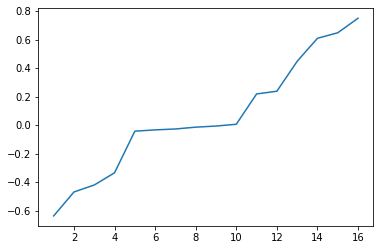

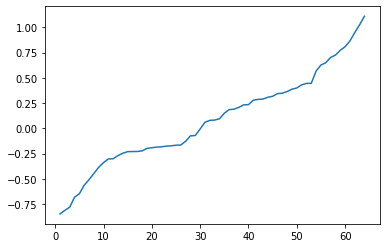

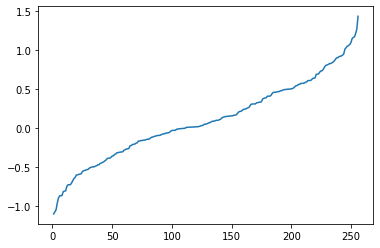

In [14]:
for k in k_list:
    sorted_delta = sorted(delta[k].values())
    x = list(range(1,len(sorted_delta)+1))
    plt.plot(x,sorted_delta)
    plt.show()

## Exercise 2

## TODO